In [1]:
import numpy as np

# creating the image
im_width = 500
im_height = 500
im = np.zeros((im_height, im_width))

# Mark the small square at the center of the frame to be 1 
# the picture has a width of 100 margin. 
im[100:im_width - 1 - 100, 100:im_height - 1 - 100] = 1

# create the data to stream from
# X_full is an array of coordinates of the square. 
# from (0,0) to (499,499)
X_full = np.transpose(
    [np.tile(np.asarray(range(im.shape[0])), im.shape[1]),
     np.repeat(np.asarray(range(im.shape[1])), im.shape[0])]
)

# map the intensity values against the grid
# y_full is the intensity values, [0, 250000)
# it is like the target array
y_full = np.asarray([im[P[0], P[1]] for P in X_full])

# It is weird, idk why they did this twice. There are no differences, seems like...


# create the data to stream from
X_full = np.transpose(
    [np.tile(np.asarray(range(im.shape[0])), im.shape[1]),
     np.repeat(np.asarray(range(im.shape[1])), im.shape[0])]
)
# map the intensity values against the grid
y_full = np.asarray([im[P[0], P[1]] for P in X_full])

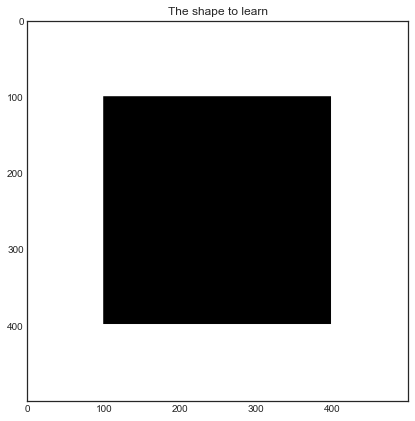

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(7, 7))
    plt.imshow(im)
    plt.title('The shape to learn')
    plt.show()

### Active learning with stream-based sampling

In [3]:
from sklearn.ensemble import RandomForestClassifier
from modAL.models import ActiveLearner

# Same as the preious tutorials, same 
# with a initial training set of 5 elements

# assembling initial training set
n_initial = 5
initial_idx = np.random.choice(range(len(X_full)), size=n_initial, replace=False)
X_train, y_train = X_full[initial_idx], y_full[initial_idx]

# initialize the learner
learner = ActiveLearner(
    estimator=RandomForestClassifier(),
    X_training=X_train, y_training=y_train
)
unqueried_score = learner.score(X_full, y_full)

print('Initial prediction accuracy: %f' % unqueried_score)

Initial prediction accuracy: 0.544612


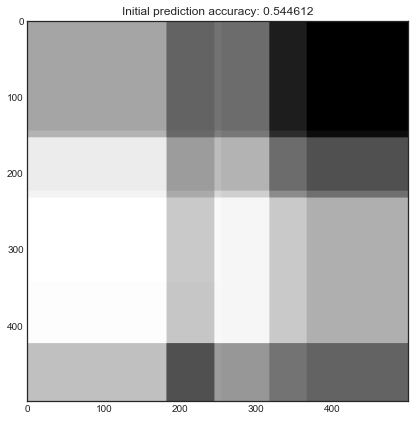

In [4]:
# visualizing initial prediciton
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(7, 7))
    prediction = learner.predict_proba(X_full)[:, 0]
    plt.imshow(prediction.reshape(im_width, im_height))
    plt.title('Initial prediction accuracy: %f' % unqueried_score)
    plt.show()

In [5]:
from modAL.uncertainty import classifier_uncertainty

performance_history = [unqueried_score]

# learning until the accuracy reaches a given threshold
while learner.score(X_full, y_full) < 0.90:
    stream_idx = np.random.choice(range(len(X_full)))
    
    # This is what I need, this function returns the uncertainty. 
    if classifier_uncertainty(learner, X_full[stream_idx].reshape(1, -1)) >= 0.4:
        learner.teach(X_full[stream_idx].reshape(1, -1), y_full[stream_idx].reshape(-1, ))
        new_score = learner.score(X_full, y_full)
        performance_history.append(new_score)
        print('Pixel no. %d queried, new accuracy: %f' % (stream_idx, new_score))

Pixel no. 3067 queried, new accuracy: 0.643052
Pixel no. 114406 queried, new accuracy: 0.733472
Pixel no. 146560 queried, new accuracy: 0.699508
Pixel no. 218294 queried, new accuracy: 0.685492
Pixel no. 87127 queried, new accuracy: 0.812000
Pixel no. 176703 queried, new accuracy: 0.780852
Pixel no. 197338 queried, new accuracy: 0.862152
Pixel no. 204578 queried, new accuracy: 0.914084


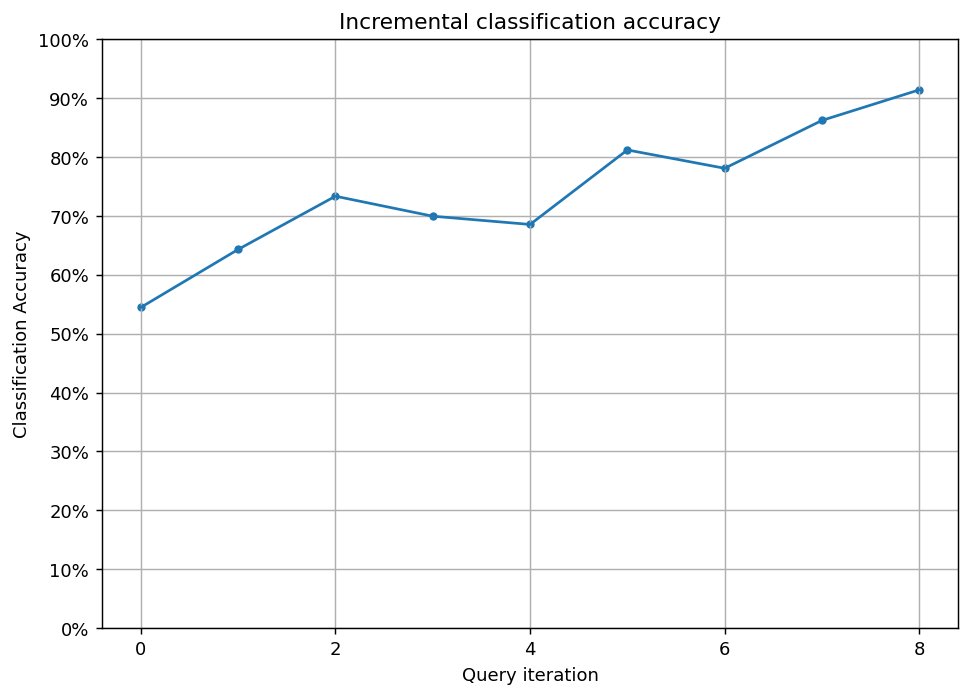

In [6]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()